# Transformer Lens Setup

This setup is copied from Neel's main demo colab notebook for Transformer Lens, which can be found here: https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/Main_Demo.ipynb#scrollTo=V-IJnEFkEBPa

In [1]:
import google.colab
IN_COLAB = True
print("Running as a Colab notebook")
%pip install git+https://github.com/neelnanda-io/TransformerLens.git
%pip install circuitsvis

# PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
# # Install another version of node that makes PySvelte work way faster
# !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
# %pip install git+https://github.com/neelnanda-io/PySvelte.git

Running as a Colab notebook
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-vhqpb5ca
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-vhqpb5ca
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit 006599b30fd6950b3b07c54eabbdaa7c36939595
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 KB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 53.0 MB/s eta 0:00

In [2]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: colab


In [3]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from torchtyping import TensorType as TT
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [4]:
%matplotlib inline
import time
import pylab as pl
import matplotlib.pyplot as plt
from IPython import display

In [5]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

In [6]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
import os
try:
  mkdir(Path('/content/'))
except:
  pass
root = Path('/content/a')
try:
  os.mkdir(root)
except:
  pass
large_root = Path('/content/b')
try:
  os.mkdir(large_root)
except:
  pass

# Creating the Model Training Class
This function will be used to train general models, given data and some evaluation function as input.

Tried to make it a class, but got very bad memory leaks. Would be nice to modularise this more nicely, but works for now!

In [9]:
# New code for Neel-style task

%matplotlib inline
import time
import pylab as pl
import matplotlib.pyplot as plt
from IPython import display


def train_model(data, fn, cfg, device='cuda', split=0.7,seed=42,num_epochs=2000):
  def cross_entropy_high_precision(logits, labels):
      logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
      prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
      loss = -torch.mean(prediction_logprobs)
      return loss

  def full_loss(model, data, labels):
      # Take the final position only
      logits = model(data)[:, -1]
      return cross_entropy_high_precision(logits, labels)

  # Do the initial setup
  # Create HookedTransformer Model
  model = HookedTransformer(cfg).to(device)
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.98), weight_decay=1.0)
  scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))
  # Generate train and test split
  random.seed(seed)
  random.shuffle(data)
  div = int(split*len(data))
  train, test = torch.tensor(data[:div]).to(device), torch.tensor(data[div:]).to(device)
  train_labels = torch.tensor([fn(x) for x in train]).to(device)
  test_labels = torch.tensor([fn(x) for x  in test]).to(device)

  #Saving the runs
  run_name = f"grok_{int(time.time())}"
  save_every = 1000
  try:
    os.mkdir(root/run_name)
  except:
    pass

  print("device =", device)

  def cross_entropy_high_precision(logits, labels):
      logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
      prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
      loss = -torch.mean(prediction_logprobs)
      return loss


  def full_loss(model, data, labels):
      # Take the final position only
      logits = model(data)[:, -1]
      return cross_entropy_high_precision(logits, labels)

  train_losses = []
  test_losses = []
  for epoch in tqdm.tqdm(range(num_epochs + 1)):
      train_loss = full_loss(model, train, train_labels)
      test_loss = full_loss(model, test, test_labels)
      train_losses.append(train_loss.item())
      test_losses.append(test_loss.item())

      train_loss.backward()
      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()
      torch.cuda.empty_cache()
        
      if epoch%save_every == 0:
          save_dict = {
                  'model': model.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  'scheduler': scheduler.state_dict(),
                  'train_loss': train_loss,
                  'test_loss': test_loss,
                  'epoch': epoch,
          }
          torch.save(save_dict, root/run_name/f"{epoch}.pth")
          print(f"Saved model to {root/run_name/f'{epoch}.pth'}")
      
      if epoch % 100 == 0:
        plt.semilogy(list([l for l in train_losses]), color="blue")
        plt.semilogy(list([l for l in test_losses]), color="red")
        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(0.01)

      if epoch % 100 == 0:
        print(f"Epoch: {epoch}. Loss: {train_loss}")
  
  return model

# Minimum of three numbers, up to n = 100

Architecture: embedding, single transformer block, unembed.

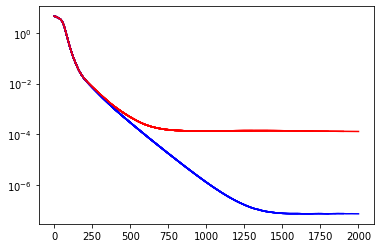

Epoch: 2000. Loss: 7.300210066981595e-08


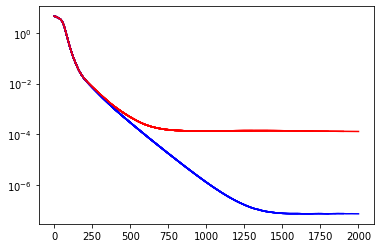

In [ ]:
# Train our first transformer again!
p = 100
d_vocab = p+1
n_ctx = 3

tiny_cfg1 = HookedTransformerConfig(
    d_model=64,
    d_head=64//1,
    n_heads=1,
    d_mlp=4*64,
    n_layers=1,
    n_ctx=n_ctx,
    act_fn="relu", #solu_ln
    d_vocab=d_vocab,
    normalization_type=None, #"LN",
    seed=23,  # Now we're training a custom model, it's good to set the seed to get reproducible results. It defaults to 42.
)

data = [(i, j, k) for i in range(p) for j in range(p) for k in range(p)]

fn = lambda x:min(x)

model = train_model(data, fn, tiny_cfg1)


# Analysing the Model

Here are some quick functions for analysing a given model

In [25]:
import circuitsvis as cv

def plot_logits(model, input):
  input = torch.tensor(input)
  logits, cache = model.run_with_cache(input, remove_batch_dim = True)
  fig, ax = plt.subplots(figsize=(40,4))
  ax.plot(logits[0][-1].cpu().detach().numpy())
  plt.show()

def generate_attn_pattern(model, input):
  input = torch.tensor(input)
  logits, cache = model.run_with_cache(input, remove_batch_dim = True)
  attn_pattern = cache["pattern", 0, "attn"]
  return cv.attention.attention_patterns(tokens = [str(t) for t in list(input.detach().cpu().numpy())], attention = attn_pattern)

def OV_copying_score(model):
  OV_circuit_all_heads = model.OV
  OV_circuit_all_heads_eigenvalues = OV_circuit_all_heads.eigenvalues 
  OV_copying_score2 = OV_circuit_all_heads_eigenvalues.sum(dim=-1).real / OV_circuit_all_heads_eigenvalues.abs().sum(dim=-1)
  return OV_copying_score2

def OV_full_copying_score(model):
  OV_circuit_all_heads = model.OV
  full_OV_circuit = model.embed.W_E @ OV_circuit_all_heads @ model.unembed.W_U
  full_OV_circuit_eigenvalues = full_OV_circuit.eigenvalues
  full_OV_copying_score = full_OV_circuit_eigenvalues.sum(dim=-1).real / full_OV_circuit_eigenvalues.abs().sum(dim=-1)
  return full_OV_copying_score

# Seeing what happens if we simply embed and then unembed
def embed_unembed_copying_score(model):
  nothing = FactoredMatrix(model.embed.W_E, model.unembed.W_U)
  nothing_eigenvalues = nothing.eigenvalues
  nothing_score = nothing_eigenvalues.sum(dim=-1).real / nothing_eigenvalues.abs().sum(dim=-1)
  return nothing_score


##Analysing our first model

# New section

In [ ]:
# Basic Inference
torch.argmax(model(torch.tensor([50, 47, 5]))[0][-1])

tensor(5, device='cuda:0')

In [ ]:
ex_logits, ex_cache = model.run_with_cache(torch.tensor([50, 47, 5]), remove_batch_dim = True)

In [ ]:
torch.argmax(model(torch.tensor([12,11,10]))[0][-1])

tensor(10, device='cuda:0')

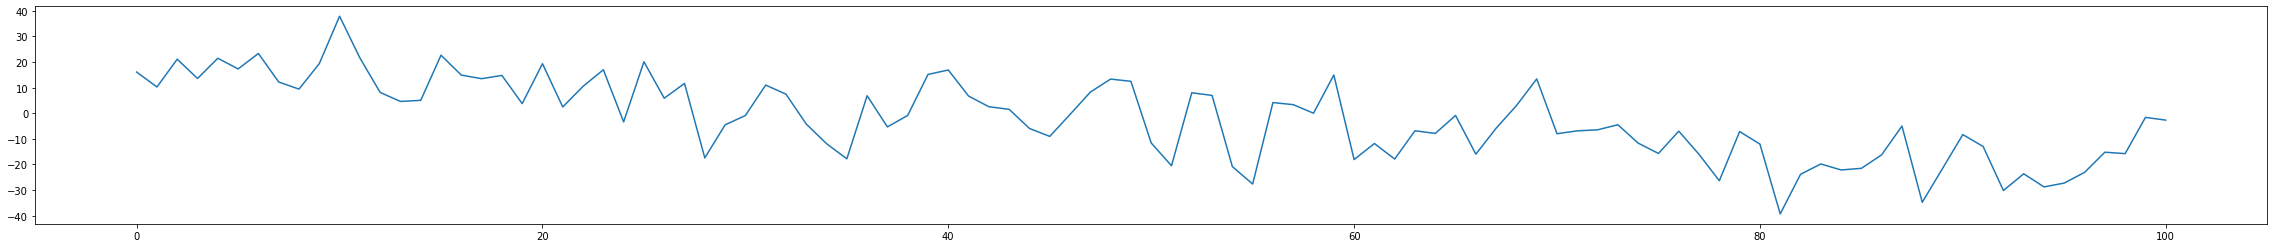

In [ ]:
plot_logits(model, [12,11,10])

In [ ]:
generate_attn_pattern(model, [20,35,50])

I'm going to look at the extent to which the OV circuit is just doing copying. I'm going to steal some of Neel's example to do this (from his Medium Example in Main Demo).

In [ ]:
OV_copying_score(model)

tensor([[0.8830]], device='cuda:0', grad_fn=<DivBackward0>)

Now we can find the OV copying score for a single model. Would be interesting to plot this against number of iterations, as well as how it changes when we change certain parameters of the model.

Here is a slightly different measure of the copying score.

In [ ]:
OV_full_copying_score(model)

FactoredMatrix: Shape(torch.Size([1, 1, 101, 101])), Hidden Dim(64)


tensor([[0.9839]], device='cuda:0', grad_fn=<DivBackward0>)

These give pretty high values for copying, which is what we might expect to occur. This gives a possible explanation for how the model is working: it is simply  

In [ ]:
embed_unembed_copying_score(model)

torch.Size([101, 64]) torch.Size([64, 101])
torch.Size([101, 101])


tensor(0.7879, device='cuda:0', grad_fn=<DivBackward0>)

Need to check this further, but this seems to suggest the OV matrix is doing more "copying" than simply the embed and unembed matrices composed together? Is this because it's taking into account the fact that some 

Experiments to do to look at this further:
1. Vary internal dimension
2. Compare to the task of "just pick the last element". Particularly, the copying score for the embed / unembed circuit.

## Repeating, with smaller internal dimension

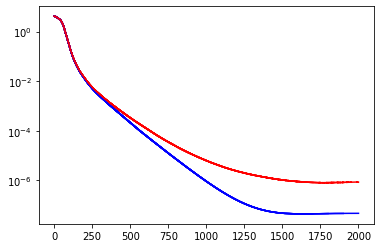

Epoch: 2000. Loss: 4.753917211181622e-08


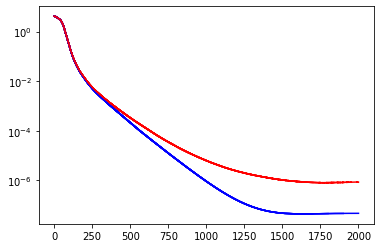

In [ ]:
# TODO: make it so that the code to train a model is wrapped in some function. Currently not working besides my original example.
p = 60
d_vocab = p+1
n_ctx = 3

tiny_cfg2 = HookedTransformerConfig(
    d_model=64,
    d_head=64//1,
    n_heads=1,
    d_mlp=4*64,
    n_layers=1,
    n_ctx=n_ctx,
    act_fn="relu", #solu_ln
    d_vocab=d_vocab,
    normalization_type=None, #"LN",
    seed=23,  # Now we're training a custom model, it's good to set the seed to get reproducible results. It defaults to 42.
)


data = [(i, j, k) for i in range(p) for j in range(p) for k in range(p)]

fn = lambda x:min(x)

small_model = train_model(data, fn, tiny_cfg2)

In [ ]:
torch.argmax(small_model(torch.tensor([50, 47, 5]))[0][-1])

tensor(5, device='cuda:0')

In [ ]:
print(OV_copying_score(small_model))
print(OV_full_copying_score(small_model))
print(embed_unembed_copying_score(small_model))

tensor([[0.8955]], device='cuda:0', grad_fn=<DivBackward0>)
FactoredMatrix: Shape(torch.Size([1, 1, 61, 61])), Hidden Dim(64)
tensor([[0.9787]], device='cuda:0', grad_fn=<DivBackward0>)
torch.Size([61, 64]) torch.Size([64, 61])
torch.Size([61, 61])
tensor(0.5731, device='cuda:0', grad_fn=<DivBackward0>)


The copying and full copyoing scores are pretty similar here to the higher dimensional transformer here, but the embed / unembed copying score is noticeably smaller!

## Training multiple models, varying model dimension, looking at different copying scores

KeyboardInterrupt: ignored

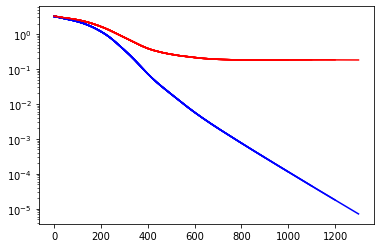

In [ ]:
p = 20
n_ctx = 2
d_vocab = p+1

data = [(i, j) for i in range(p) for j in range(p)]

fn = lambda x:min(x)

models = []

for d_model in range(10,51,5):
  cfg = HookedTransformerConfig(
    d_model=d_model,
    d_head=d_model//1,
    n_heads=1,
    d_mlp=4*d_model,
    n_layers=1,
    n_ctx=n_ctx,
    act_fn="relu", #solu_ln
    d_vocab=d_vocab,
    normalization_type=None, #"LN",
    seed=23,  # Now we're training a custom model, it's good to set the seed to get reproducible results. It defaults to 42.
  )
  model = train_model(data, fn, cfg)
  models.append(model)





In [ ]:
OV_copy_scores = []
OV_full_copying_scores = []
embed_unembed_copying_scores = []
for model in models:
  OV_copy_scores.append(OV_copying_score(model))
  OV_full_copying_scores.append(OV_full_copying_score(model))
  embed_unembed_copying_scores.append(embed_unembed_copying_score(model))

FactoredMatrix: Shape(torch.Size([1, 1, 61, 61])), Hidden Dim(10)
torch.Size([61, 10]) torch.Size([10, 61])
torch.Size([61, 61])
FactoredMatrix: Shape(torch.Size([1, 1, 61, 61])), Hidden Dim(15)
torch.Size([61, 15]) torch.Size([15, 61])
torch.Size([61, 61])
FactoredMatrix: Shape(torch.Size([1, 1, 61, 61])), Hidden Dim(20)
torch.Size([61, 20]) torch.Size([20, 61])
torch.Size([61, 61])
FactoredMatrix: Shape(torch.Size([1, 1, 61, 61])), Hidden Dim(25)
torch.Size([61, 25]) torch.Size([25, 61])
torch.Size([61, 61])
FactoredMatrix: Shape(torch.Size([1, 1, 61, 61])), Hidden Dim(30)
torch.Size([61, 30]) torch.Size([30, 61])
torch.Size([61, 61])
FactoredMatrix: Shape(torch.Size([1, 1, 61, 61])), Hidden Dim(35)
torch.Size([61, 35]) torch.Size([35, 61])
torch.Size([61, 61])
FactoredMatrix: Shape(torch.Size([1, 1, 61, 61])), Hidden Dim(40)
torch.Size([61, 40]) torch.Size([40, 61])
torch.Size([61, 61])
FactoredMatrix: Shape(torch.Size([1, 1, 61, 61])), Hidden Dim(45)
torch.Size([61, 45]) torch.Size

In [ ]:
print([float(score) for score in OV_copy_scores])

[0.838102400302887, 0.8954758048057556, 0.937965452671051, 0.8623117804527283, 0.9541850686073303, 0.9165216088294983, 0.9328360557556152, 0.9110330939292908, 0.9346674084663391]


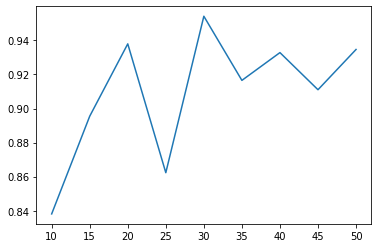

In [ ]:
plt.plot(range(10,51,5), [float(score) for score in OV_copy_scores]) 

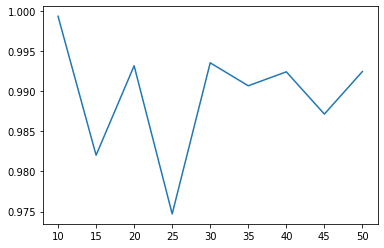

In [ ]:
plt.plot(range(10,51,5), [float(score) for score in OV_full_copying_scores]) 

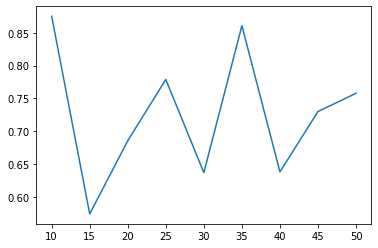

In [ ]:
plt.plot(range(10,51,5), [float(score) for score in embed_unembed_copying_scores]) 

Hypothesis: for d_model < p, maybe some kind of relationship? 

## Train for much smaller d_model than p

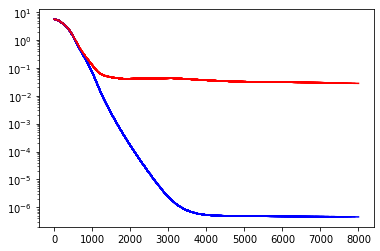

Epoch: 8000. Loss: 4.525656734940685e-07


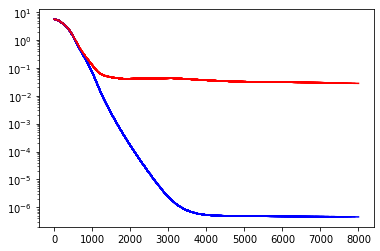

In [10]:
# TODO: make it so that the code to train a model is wrapped in some function. Currently not working besides my original example.
p = 256
d_vocab = p+1
n_ctx = 2

d_model = 8

tiny_cfg2 = HookedTransformerConfig(
    d_model=d_model,
    d_head=d_model//1,
    n_heads=1,
    d_mlp=4*d_model,
    n_layers=1,
    n_ctx=n_ctx,
    act_fn="relu", #solu_ln
    d_vocab=d_vocab,
    normalization_type=None, #"LN",
    seed=23,  # Now we're training a custom model, it's good to set the seed to get reproducible results. It defaults to 42.
)


data = [(i, j) for i in range(p) for j in range(p)]

fn = lambda x:min(x)

small_model = train_model(data, fn, tiny_cfg2, num_epochs=8000)

In [13]:
print(OV_copying_score(small_model))
print(OV_full_copying_score(small_model))
print(embed_unembed_copying_score(small_model))

tensor([[0.9930]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[1.]], device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9719, device='cuda:0', grad_fn=<DivBackward0>)


This is doing loads of copying!

Let's compare this a bit more clearly, as d_model increases

 But its loss on test dist is decidely worse than earlier on triples - 

## What happens with layer norm?

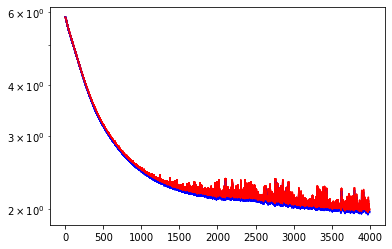

Epoch: 4000. Loss: 1.963028506965203


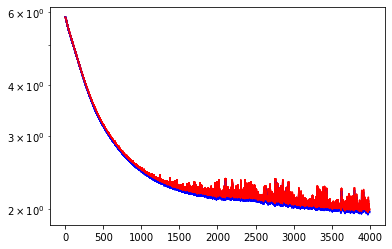

In [19]:
# TODO: make it so that the code to train a model is wrapped in some function. Currently not working besides my original example.
p = 256
d_vocab = p+1
n_ctx = 2

d_model = 8

tiny_cfg2 = HookedTransformerConfig(
    d_model=d_model,
    d_head=d_model//1,
    n_heads=1,
    d_mlp=4*d_model,
    n_layers=1,
    n_ctx=n_ctx,
    act_fn="relu", #solu_ln
    d_vocab=d_vocab,
    normalization_type="LN", #"LN",
    seed=23,  # Now we're training a custom model, it's good to set the seed to get reproducible results. It defaults to 42.
)


data = [(i, j) for i in range(p) for j in range(p)]

fn = lambda x:min(x)

small_model = train_model(data, fn, tiny_cfg2, num_epochs=4000)

In [20]:
print(OV_copying_score(small_model))
print(OV_full_copying_score(small_model))
print(embed_unembed_copying_score(small_model))

tensor([[0.9970]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[0.9651]], device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8048, device='cuda:0', grad_fn=<DivBackward0>)


In [22]:
torch.argmax(small_model(torch.tensor([]))[0][-1])

tensor(7, device='cuda:0')

Think this has basically learned nothing

Here we have big time struggles when we include layer norm, with small dimension of model!

Let's see if this still holds for higher d_model


In [17]:
p = 256
d_vocab = p+1
n_ctx = 2

d_model = 128

tiny_cfg2 = HookedTransformerConfig(
    d_model=d_model,
    d_head=d_model//1,
    n_heads=1,
    d_mlp=4*d_model,
    n_layers=1,
    n_ctx=n_ctx,
    act_fn="relu", #solu_ln
    d_vocab=d_vocab,
    normalization_type="LN", #"LN",
    seed=23,  # Now we're training a custom model, it's good to set the seed to get reproducible results. It defaults to 42.
)


data = [(i, j) for i in range(p) for j in range(p)]

fn = lambda x:min(x)

small_model = train_model(data, fn, tiny_cfg2, num_epochs=8000)

Moving model to device:  cuda


KeyboardInterrupt: ignored

Looks like LN gives us some exploding gradients! cringe

In [16]:
print(OV_copying_score(small_model))
print(OV_full_copying_score(small_model))
print(embed_unembed_copying_score(small_model))

tensor([[-0.3988]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[0.8871]], device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0662, device='cuda:0', grad_fn=<DivBackward0>)


Might be because of the exploding gradients stuff, but it at least looks like we are no longer getting the same copying behaviour! Full OV says yes, but standard OV says no.

I want to see if I can get 

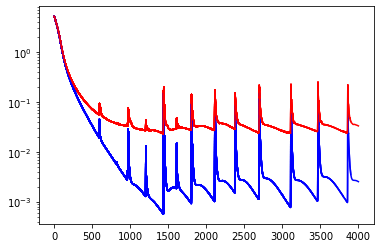

Epoch: 4000. Loss: 0.0025262707918323633


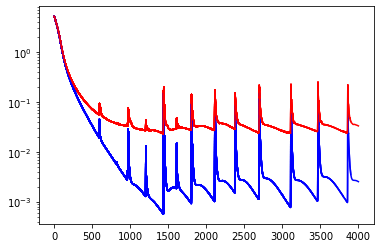

In [25]:
p = 128
d_vocab = p+1
n_ctx = 2

d_model = 32

tiny_cfg2 = HookedTransformerConfig(
    d_model=d_model,
    d_head=d_model//1,
    n_heads=1,
    d_mlp=4*d_model,
    n_layers=1,
    n_ctx=n_ctx,
    act_fn="relu", #solu_ln
    d_vocab=d_vocab,
    normalization_type="LN", #"LN",
    seed=23,  # Now we're training a custom model, it's good to set the seed to get reproducible results. It defaults to 42.
)


data = [(i, j) for i in range(p) for j in range(p)]

fn = lambda x:min(x)

small_model = train_model(data, fn, tiny_cfg2, num_epochs=4000)

In [26]:
print(OV_copying_score(small_model))
print(OV_full_copying_score(small_model))
print(embed_unembed_copying_score(small_model))

tensor([[-0.1161]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[0.8036]], device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.0230, device='cuda:0', grad_fn=<DivBackward0>)


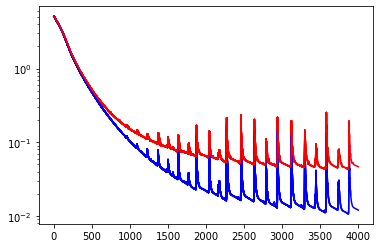

Epoch: 4000. Loss: 0.01198648038134486


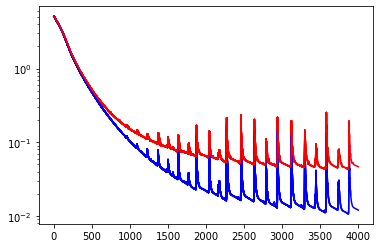

In [28]:
p = 128
d_vocab = p+1
n_ctx = 2

d_model = 16

tiny_cfg2 = HookedTransformerConfig(
    d_model=d_model,
    d_head=d_model//1,
    n_heads=1,
    d_mlp=4*d_model,
    n_layers=1,
    n_ctx=n_ctx,
    act_fn="relu", #solu_ln
    d_vocab=d_vocab,
    normalization_type="LN", #"LN",
    seed=23,  # Now we're training a custom model, it's good to set the seed to get reproducible results. It defaults to 42.
)


data = [(i, j) for i in range(p) for j in range(p)]

fn = lambda x:min(x)

small_model = train_model(data, fn, tiny_cfg2, num_epochs=4000)

In [29]:
print(OV_copying_score(small_model))
print(OV_full_copying_score(small_model))
print(embed_unembed_copying_score(small_model))

tensor([[0.3979]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[0.8919]], device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4732, device='cuda:0', grad_fn=<DivBackward0>)


## What if we just get rid of the mlp layer?

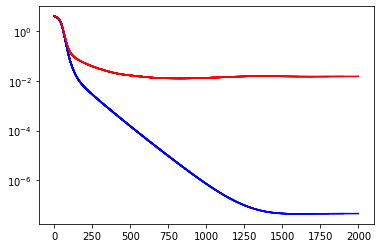

Epoch: 2000. Loss: 4.4376436294410785e-08


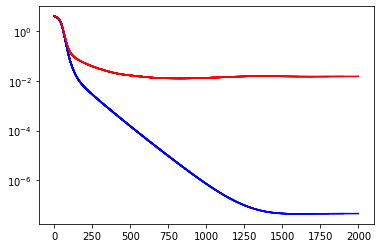

In [10]:
p = 60
d_vocab = p+1
n_ctx = 2

tiny_cfg2 = HookedTransformerConfig(
    d_model=64,
    d_head=64//1,
    n_heads=1,
    d_mlp=4*64,
    n_layers=1,
    n_ctx=n_ctx,
    act_fn="relu", #solu_ln
    d_vocab=d_vocab,
    normalization_type=None, #"LN",
    seed=23,  # Now we're training a custom model, it's good to set the seed to get reproducible results. It defaults to 42.
)


data = [(i, j) for i in range(p) for j in range(p)]

fn = lambda x:min(x)

small_model = train_model(data, fn, tiny_cfg2)

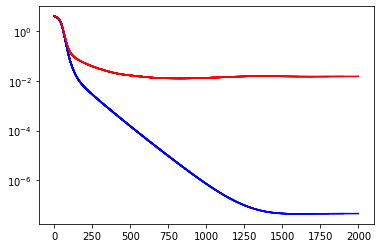

Epoch: 2000. Loss: 4.4376436294410785e-08


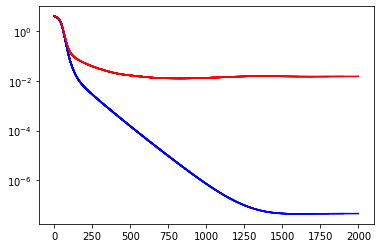

In [11]:
# Same as above, no MLP layer!
p = 60
d_vocab = p+1
n_ctx = 2

tiny_cfg2 = HookedTransformerConfig(
    d_model=64,
    d_head=64//1,
    n_heads=1,
    #d_mlp=1,
    n_layers=1,
    n_ctx=n_ctx,
    act_fn="relu", #solu_ln
    d_vocab=d_vocab,
    normalization_type=None, #"LN",
    seed=23,  # Now we're training a custom model, it's good to set the seed to get reproducible results. It defaults to 42.
)


data = [(i, j) for i in range(p) for j in range(p)]

fn = lambda x:min(x)

small_model = train_model(data, fn, tiny_cfg2)


In [14]:
list(small_model.modules())

[HookedTransformer(
   (embed): Embed()
   (hook_embed): HookPoint()
   (pos_embed): PosEmbed()
   (hook_pos_embed): HookPoint()
   (blocks): ModuleList(
     (0): TransformerBlock(
       (ln1): Identity()
       (ln2): Identity()
       (attn): Attention(
         (hook_k): HookPoint()
         (hook_q): HookPoint()
         (hook_v): HookPoint()
         (hook_z): HookPoint()
         (hook_attn_scores): HookPoint()
         (hook_pattern): HookPoint()
         (hook_result): HookPoint()
       )
       (mlp): MLP(
         (hook_pre): HookPoint()
         (hook_post): HookPoint()
       )
       (hook_attn_out): HookPoint()
       (hook_mlp_out): HookPoint()
       (hook_resid_pre): HookPoint()
       (hook_resid_mid): HookPoint()
       (hook_resid_post): HookPoint()
     )
   )
   (unembed): Unembed()
 ), Embed(), HookPoint(), PosEmbed(), HookPoint(), ModuleList(
   (0): TransformerBlock(
     (ln1): Identity()
     (ln2): Identity()
     (attn): Attention(
       (hook_k): HookP

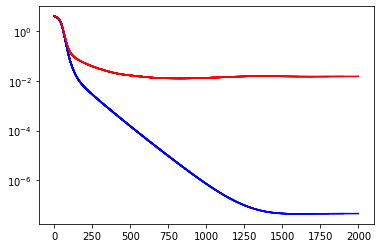

Epoch: 2000. Loss: 4.4376436294410785e-08


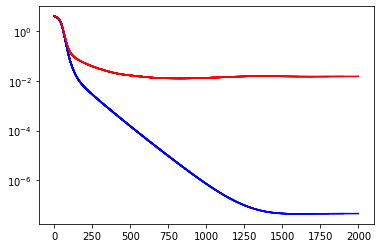

In [15]:
# Same as above, no MLP layer!
p = 60
d_vocab = p+1
n_ctx = 2

nomlp_cfg = HookedTransformerConfig(
    d_model=64,
    d_head=64//1,
    n_heads=1,
    #d_mlp=1,
    n_layers=1,
    n_ctx=n_ctx,
    act_fn="relu", #solu_ln
    d_vocab=d_vocab,
    normalization_type=None, #"LN",
    seed=23,  # Now we're training a custom model, it's good to set the seed to get reproducible results. It defaults to 42.
)


data = [(i, j) for i in range(p) for j in range(p)]

fn = lambda x:min(x)

nomlp_model = train_model(data, fn, nomlp_cfg)

In [16]:
list(nomlp_model.modules())

[HookedTransformer(
   (embed): Embed()
   (hook_embed): HookPoint()
   (pos_embed): PosEmbed()
   (hook_pos_embed): HookPoint()
   (blocks): ModuleList(
     (0): TransformerBlock(
       (ln1): Identity()
       (ln2): Identity()
       (attn): Attention(
         (hook_k): HookPoint()
         (hook_q): HookPoint()
         (hook_v): HookPoint()
         (hook_z): HookPoint()
         (hook_attn_scores): HookPoint()
         (hook_pattern): HookPoint()
         (hook_result): HookPoint()
       )
       (mlp): MLP(
         (hook_pre): HookPoint()
         (hook_post): HookPoint()
       )
       (hook_attn_out): HookPoint()
       (hook_mlp_out): HookPoint()
       (hook_resid_pre): HookPoint()
       (hook_resid_mid): HookPoint()
       (hook_resid_post): HookPoint()
     )
   )
   (unembed): Unembed()
 ), Embed(), HookPoint(), PosEmbed(), HookPoint(), ModuleList(
   (0): TransformerBlock(
     (ln1): Identity()
     (ln2): Identity()
     (attn): Attention(
       (hook_k): HookP

In [17]:
help(nomlp_model)

Help on HookedTransformer in module transformer_lens.HookedTransformer object:

class HookedTransformer(transformer_lens.hook_points.HookedRootModule)
 |  HookedTransformer(cfg, tokenizer=None, move_to_device=True)
 |  
 |  This class implements a full Transformer using the components in ./components.py, with
 |  HookPoints on every interesting activation. It inherits from HookedRootModule.
 |  
 |  It can have a pretrained Transformer's weights automatically loaded in via the HookedTransformer.from_pretrained class method. It can also be instantiated with randomly initialized weights via __init__ and being passed a dict or HookedTransformerConfig object.
 |  
 |  Method resolution order:
 |      HookedTransformer
 |      transformer_lens.hook_points.HookedRootModule
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, cfg, tokenizer=None, move_to_device=True)
 |      Model initialization. Note that if you want to load th

In [18]:
nomlp_model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): Identity()
      (ln2): Identity()
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_mid): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)

# Current Hypotheses about what is going on

I think maybe that when we introduce layer norm, it is unable to do the task of "copying" that it might want to:

# Trying to interpret the super simple model


The interesting thing above was "how does compressing the numbers into a smaller dimensional space change the dynamics?". Before I do that, I want to really, really nail down how the simplest possible transformer works

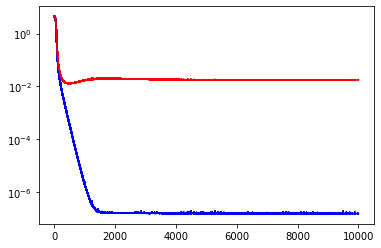

Epoch: 10000. Loss: 1.4638144321948147e-07


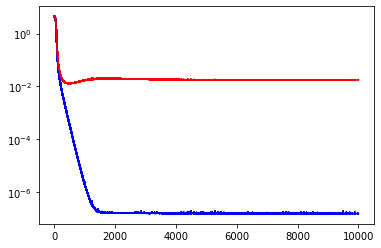

In [21]:
# TODO: make it so that the code to train a model is wrapped in some function. Currently not working besides my original example.
p = 100
d_vocab = p+1
n_ctx = 2

tiny_cfg2 = HookedTransformerConfig(
    d_model=128,
    d_head=128//1,
    n_heads=1,
    attn_only=True,
    n_layers=1,
    n_ctx=n_ctx,
    act_fn="relu", #solu_ln
    d_vocab=d_vocab,
    normalization_type=None, #"LN",
    seed=23,  # Now we're training a custom model, it's good to set the seed to get reproducible results. It defaults to 42.
)


data = [(i, j) for i in range(p) for j in range(p)]

fn = lambda x:min(x)

small_model = train_model(data, fn, tiny_cfg2, num_epochs=10000)

In [ ]:
small_model

In [26]:
print(OV_copying_score(small_model))
print(OV_full_copying_score(small_model))
print(embed_unembed_copying_score(small_model))

tensor([[0.9832]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[0.9986]], device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9731, device='cuda:0', grad_fn=<DivBackward0>)


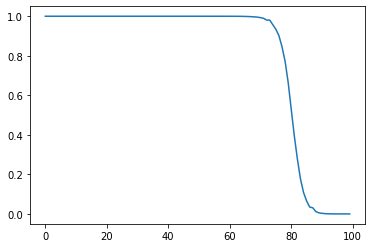

In [34]:
# Hold the second token constant, look at the attention pattern
attn_to_i = []
for i in range(100):
  input = torch.tensor([i, 80])
  logits, cache = small_model.run_with_cache(input, remove_batch_dim = True)
  attn_pattern = cache["pattern", 0, "attn"]
  attn_to_i.append(float(attn_pattern[0][-1][0]))

plt.plot(range(100), attn_to_i)


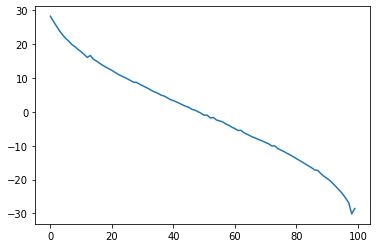

In [66]:
# Hold the second token constant, look at the attention pattern
attn_to_69 = []
attn_to_42 = []
for i in range(100):
  input69 = torch.tensor([i, 69])
  logits, cache = small_model.run_with_cache(input69, remove_batch_dim = True)
  attn_pattern69 = cache["attn_scores", 0, "attn"]
  attn_to_69.append(float(attn_pattern69[0][-1][0]))
  input42 = torch.tensor([i, 42])
  logits, cache = small_model.run_with_cache(input42, remove_batch_dim = True)
  attn_pattern42 = cache["attn_scores", 0, "attn"]
  attn_to_42.append(float(attn_pattern42[0][-1][0]))

plt.plot(range(100), attn_to_69)

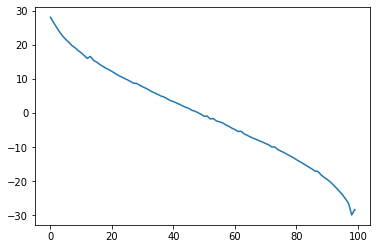

In [67]:
plt.plot(range(100), attn_to_42)

In [ ]:
attn_to_69

In [ ]:
attn_to_42

In [71]:
attn_diff = [a - b for (a,b) in zip(attn_to_69, attn_to_42)]

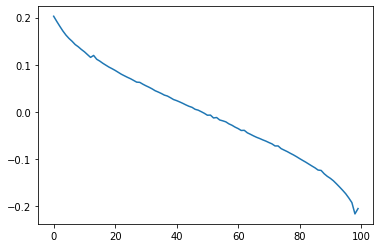

In [73]:
plt.plot(range(100), attn_diff)

In [74]:
# That's super weird!! Let's do it again!!

attn_to_89 = []
attn_to_21 = []
for i in range(100):
  input89 = torch.tensor([i, 89])
  logits, cache = small_model.run_with_cache(input89, remove_batch_dim = True)
  attn_pattern89 = cache["attn_scores", 0, "attn"]
  attn_to_89.append(float(attn_pattern89[0][-1][0]))
  input21 = torch.tensor([i, 21])
  logits, cache = small_model.run_with_cache(input21, remove_batch_dim = True)
  attn_pattern21 = cache["attn_scores", 0, "attn"]
  attn_to_21.append(float(attn_pattern21[0][-1][0]))

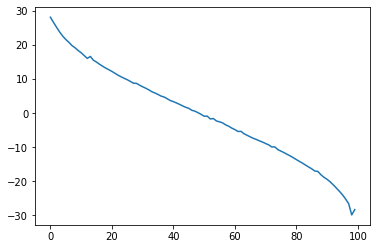

In [75]:
plt.plot(range(100), attn_to_89)

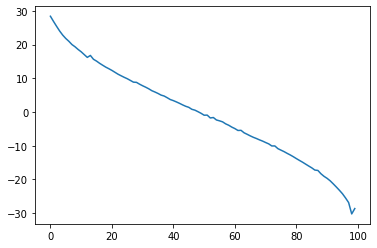

In [76]:
plt.plot(range(100), attn_to_21)

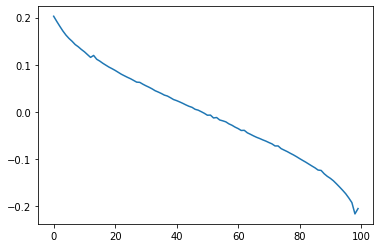

In [80]:
plt.plot(range(100), [a - b for (a,b) in zip(attn_to_69, attn_to_)])

In [81]:
attn_to_31 = []
for i in range(100):
  input31 = torch.tensor([i, 69])
  logits, cache = small_model.run_with_cache(input31, remove_batch_dim = True)
  attn_pattern31 = cache["attn_scores", 0, "attn"]
  attn_to_31.append(float(attn_pattern31[0][-1][0]))

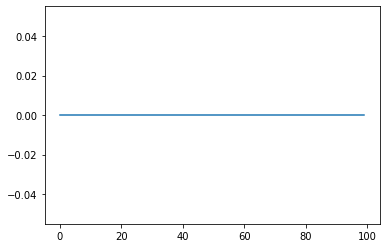

In [82]:
plt.plot(range(100), [a - b for (a,b) in zip(attn_to_69, attn_to_31)])

In [89]:
attn_to_69 == attn_to_31

True

In [84]:
def make_attn_to_n(n):
  attn_to_n = []
  for i in range(100):
    inputn = torch.tensor([i, n])
    logits, cache = small_model.run_with_cache(inputn, remove_batch_dim = True)
    attn_pattern = cache["attn_scores", 0, "attn"]
    attn_to_n.append(float(attn_pattern[0][-1][0]))
  return attn_to_n

In [85]:
attn_to_80 = make_attn_to_n(80)
attn_to_20 = make_attn_to_n(20)

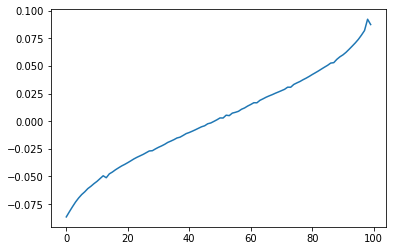

In [88]:
plt.plot(range(100), [a - b for (a,b) in zip(attn_to_80, attn_to_20)])

Weird stuff!

Getting a little look at the logits:

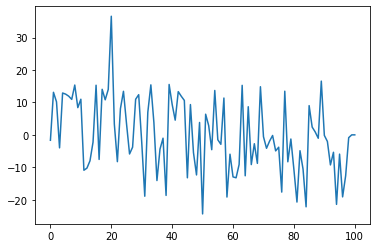

In [108]:
input = torch.tensor([50, 20])
logits, cache = small_model.run_with_cache(input, remove_batch_dim = True)
plt.plot(logits[0][-1].cpu().detach().numpy())
plt.show()